### import neccesary libaries 

In [2]:
# Step 1: Import necessary libraries

# Data handling and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Text preprocessing
import re
import string

# Machine learning models and evaluation
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Deep learning
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# To ignore unnecessary warnings
import warnings
warnings.filterwarnings("ignore")


### Step 2: Load Data + EDA

In [14]:
# load the data
df = pd.read_csv('../data/dataset.csv', encoding='ISO-8859-1')
# df.head

# Rename columns for clarity
df.columns = ["sentiment", "id", "date", "query", "user", "text"]

# Keep only sentiment and text
df = df[["sentiment", "text"]]

# Convert sentiment 4 to 1 (so we have 0 = negative, 1 = positive)
df["sentiment"] = df["sentiment"].apply(lambda x: 0 if x == 0 else 1)


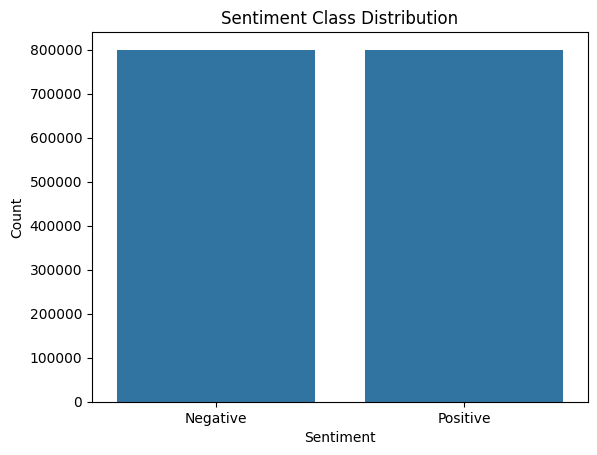

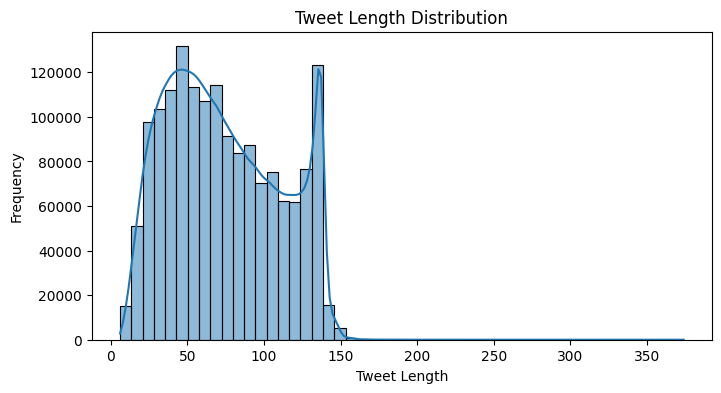

In [ ]:
# Show class distribution
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x='sentiment')
plt.title('Sentiment Class Distribution')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


# Add a new column: tweet length
df['text_length'] = df['text'].apply(len)

# Plot tweet length distribution
plt.figure(figsize=(8, 4))
sns.histplot(df['text_length'], bins=50, kde=True)
plt.title('Tweet Length Distribution')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()

In [17]:
# Show a few example rows
print("Sample tweets:")
print(df.sample(5))

Sample tweets:
         sentiment                                               text  \
352134           0              @timidheathen Ah! That's never good.    
1521275          1  @mandiiurie Thanks for the good talk, I enjoye...   
1111200          1  @tj_casey Howdy TJ, thanks and I should have s...   
585585           0  @mr_billiam maybe a tad better than yesterday....   
1279550          1  @nike620 Yay go you!! P.S. Catherine thought y...   

         text_length  
352134            37  
1521275           85  
1111200           98  
585585           134  
1279550           73  


### Step 3: Code for Text Cleaning

In [19]:
# Step 3: Clean the text data

def clean_text(text):
    text = text.lower()  # lowercase
    text = re.sub(r'@[\w_]+', '', text)  # remove mentions
    text = re.sub(r'http\S+|www.\S+', '', text)  # remove URLs
    text = re.sub(r'[^a-z\s]', '', text)  # remove punctuation and numbers
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra spaces
    return text

# Apply cleaning to the text column
df['clean_text'] = df['text'].apply(clean_text)

# Show some cleaned samples
print("Before cleaning:", df['text'].iloc[0])
print("After cleaning :", df['clean_text'].iloc[0])

Before cleaning: is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!
After cleaning : is upset that he cant update his facebook by texting it and might cry as a result school today also blah


 ### Step 4: TF-IDF Vectorization

In [20]:
# Step 4: Convert text to TF-IDF vectors

from sklearn.feature_extraction.text import TfidfVectorizer

# Create the TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=5000)  # limit to top 5000 words

# Apply to clean text
X = tfidf.fit_transform(df['clean_text'])

# Labels
y = df['sentiment']

# Split into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("TF-IDF shape:", X.shape)
print("Training size:", X_train.shape)
print("Testing size:", X_test.shape)


TF-IDF shape: (1599999, 5000)
Training size: (1279999, 5000)
Testing size: (320000, 5000)


### Step 5: Traditional Model Training + Hyperparameter Tuning

🔹 Baseline Logistic Regression Accuracy: 0.790978125

Classification Report (Baseline):
               precision    recall  f1-score   support

           0       0.80      0.78      0.79    159494
           1       0.78      0.80      0.79    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



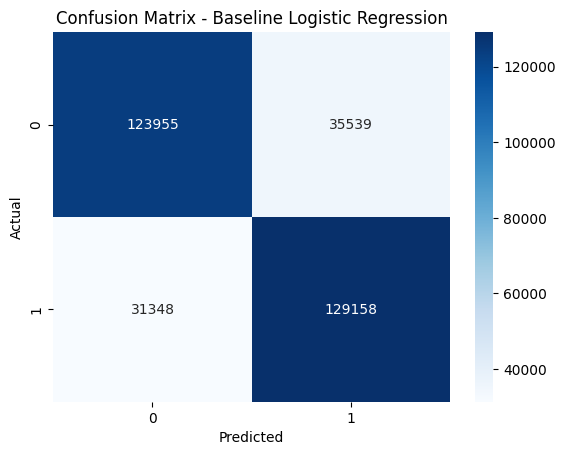

Fitting 3 folds for each of 8 candidates, totalling 24 fits

✅ Best Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
🔹 Tuned Logistic Regression Accuracy: 0.790946875

Classification Report (Tuned):
               precision    recall  f1-score   support

           0       0.80      0.78      0.79    159494
           1       0.78      0.80      0.79    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



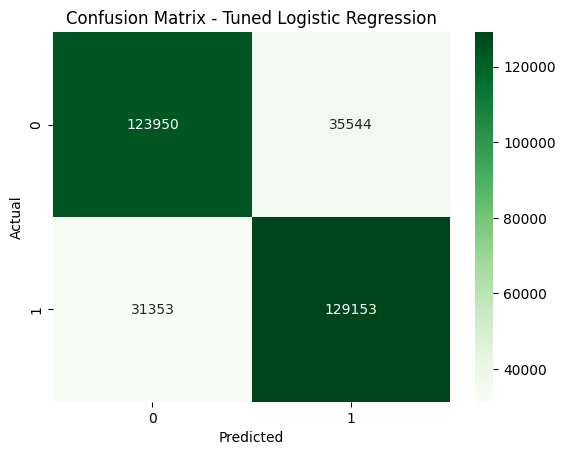

In [21]:
# Step 5: Train and fine-tune Logistic Regression model

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV


# --- Train baseline model ---
baseline_lr = LogisticRegression(max_iter=1000)
baseline_lr.fit(X_train, y_train)
y_pred_baseline = baseline_lr.predict(X_test)

print("🔹 Baseline Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_baseline))
print("\nClassification Report (Baseline):\n", classification_report(y_test, y_pred_baseline))

# Plot confusion matrix (baseline)
sns.heatmap(confusion_matrix(y_test, y_pred_baseline), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Baseline Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# --- Hyperparameter tuning with GridSearchCV ---
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear', 'saga']
}

grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=3, scoring='accuracy', verbose=1)
grid.fit(X_train, y_train)

# Best model evaluation
best_lr = grid.best_estimator_
y_pred_best = best_lr.predict(X_test)

print("\n✅ Best Parameters:", grid.best_params_)
print("🔹 Tuned Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_best))
print("\nClassification Report (Tuned):\n", classification_report(y_test, y_pred_best))

# Plot confusion matrix (tuned model)
sns.heatmap(confusion_matrix(y_test, y_pred_best), annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix - Tuned Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


### Step 6: Code for Tokenization & Padding

In [22]:
# Step 6: Tokenize and pad text for LSTM model

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Parameters
vocab_size = 10000  # Max number of words to keep
max_len = 100       # Max tweet length (cut or pad to this length)

# Tokenization
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(df['clean_text'])

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(df['clean_text'])

# Pad sequences
X_seq = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

# Labels
y_seq = df['sentiment'].values

# Train/test split
X_seq_train, X_seq_test, y_seq_train, y_seq_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

print("Vocabulary size:", len(tokenizer.word_index))
print("Shape of padded sequences:", X_seq.shape)


Vocabulary size: 418043
Shape of padded sequences: (1599999, 100)


 ### Step 7: Code for LSTM Model

In [23]:
# Step 7: Build and train LSTM model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Define model
embedding_dim = 64

lstm_model = Sequential([
    Embedding(input_dim=10000, output_dim=embedding_dim, input_length=100),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile model
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
history = lstm_model.fit(
    X_seq_train, y_seq_train,
    epochs=3,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)


Epoch 1/3
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 1297s 81ms/step - accuracy: 0.4994 - loss: 0.6933 - val_accuracy: 0.4999 - val_loss: 0.6932
Epoch 2/3
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 1184s 74ms/step - accuracy: 0.4994 - loss: 0.6932 - val_accuracy: 0.4999 - val_loss: 0.6932
Epoch 3/3
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 1361s 85ms/step - accuracy: 0.4992 - loss: 0.6932 - val_accuracy: 0.5001 - val_loss: 0.6931


🔹 LSTM Test Accuracy: 0.4984
🔹 LSTM Test Loss: 0.6932


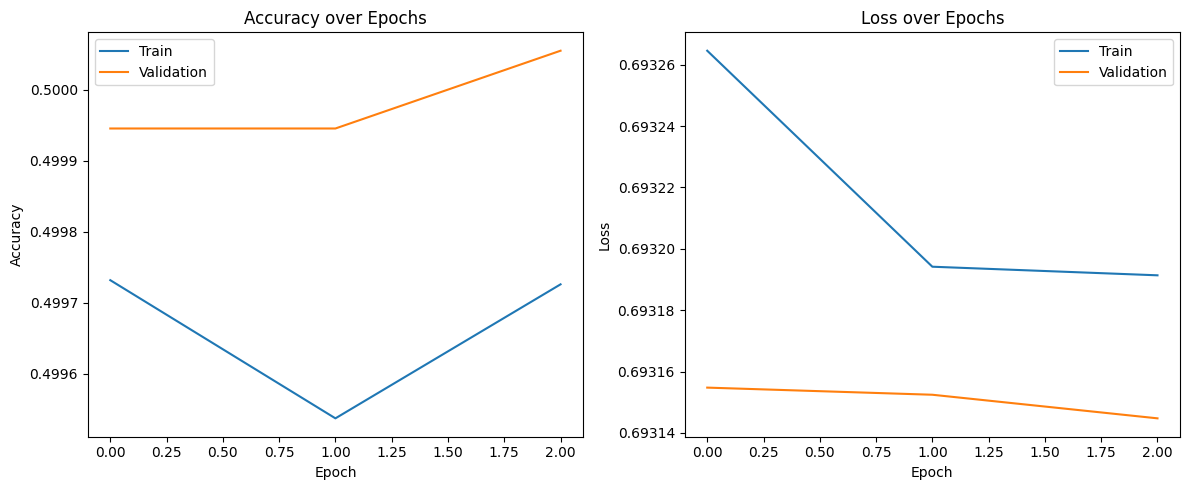

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 213s 21ms/step

Classification Report (LSTM):
               precision    recall  f1-score   support

           0       0.50      1.00      0.67    159494
           1       0.00      0.00      0.00    160506

    accuracy                           0.50    320000
   macro avg       0.25      0.50      0.33    320000
weighted avg       0.25      0.50      0.33    320000



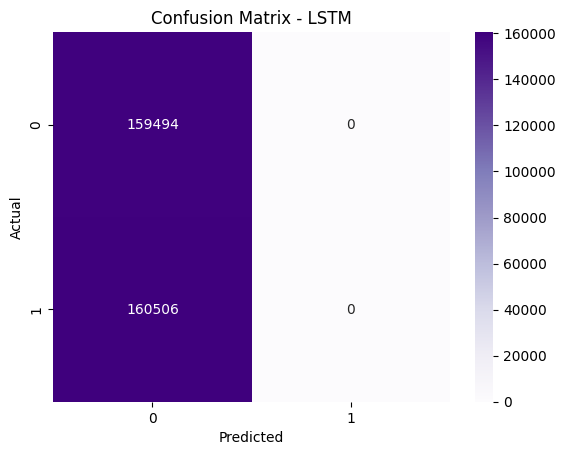

In [24]:
# Evaluate on test set
test_loss, test_acc = lstm_model.evaluate(X_seq_test, y_seq_test, verbose=0)
print(f"🔹 LSTM Test Accuracy: {test_acc:.4f}")
print(f"🔹 LSTM Test Loss: {test_loss:.4f}")

# Plot training history
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Predict and report
y_pred_lstm = (lstm_model.predict(X_seq_test) > 0.5).astype("int32")
print("\nClassification Report (LSTM):\n", classification_report(y_seq_test, y_pred_lstm))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_seq_test, y_pred_lstm), annot=True, fmt="d", cmap="Purples")
plt.title("Confusion Matrix - LSTM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()